## Bayesian
The Bayesian method truly shines when dealing with small sample sizes because it avoids the pitfalls of the frequentist normal approximation.When you have $N < 30$ (or, more precisely, few conversions), the traditional Z-test becomes highly inaccurate, but the Bayesian model remains robust.I'll provide you with a Python script that implements a simple Bayesian A/B test. This script will allow you to input a very small sample size and immediately get the key output: the Probability of Superiority.

#### Applying Bayesian A/B Testing to Small Samples
The technique relies on the Beta distribution to model the true conversion rate for each group. The Beta distribution is defined by two parameters: $\alpha$ (successes) and $\beta$ (failures).

1. The Prior (Start State)
- We begin with a Prior distribution representing our initial knowledge before the test starts. For A/B testing, we typically use a non-informative prior like $\text{Beta}(1, 1)$.
    - $\text{Prior for } p_A: \text{Beta}(\alpha=1, \beta=1)$
    - $\text{Prior for } p_B: \text{Beta}(\alpha=1, \beta=1)$
2. The Posterior (Updated State)
- As soon as you run the experiment and collect data ($X$ conversions and $N-X$ non-conversions), the Posterior distribution is calculated instantly using a simple update rule:
    - $\text{Posterior for } p_A: \text{Beta}(\alpha = \text{Prior Successes} + \text{Test Conversions}, \beta = \text{Prior Failures} + \text{Test Non-Conversions})$

Using the non-informative $\text{Beta}(1, 1)$:
- $\text{Posterior for } p_A: \text{Beta}(1 + X_A, 1 + N_A - X_A)$
- $\text{Posterior for } p_B: \text{Beta}(1 + X_B, 1 + N_B - X_B)$

3. The Final Calculation (Monte Carlo Simulation)
- The final step is to determine the Probability of Superiority ($\text{P}(p_B > p_A)$). Since there's no simple closed-form solution, we use a Monte Carlo simulation:
    1. Randomly draw a large number of samples (e.g., 50,000) from the Posterior distribution of $p_A$.
    2. Randomly draw the same number of samples from the Posterior distribution of $p_B$.
    3. Count how many times the sample from $p_B$ is greater than the sample from $p_A$.
    4. Divide that count by 50,000.

#### Key Takeaway on Interpretation
- For this method, you don't look for a p-value less than $0.05$. Instead, you look for the Probability of B being Better than A to exceed a fixed business threshold (usually 95% or 99%).

In [1]:
import numpy as np
from scipy.stats import beta
np.random.seed(1776)
# --- Input: Small Sample Data ---
# Test this with small numbers to see the robustness of the method!

# Group A (Control - Old Page)
conversions_A = 8  # X_A
users_A = 25       # N_A

# Group B (Experimental - New Page)
conversions_B = 12 # X_B
users_B = 27       # N_B

# --- 1. Calculate Posterior Distribution Parameters ---
# We use a non-informative prior: Beta(alpha=1, beta=1)
# Posterior Alpha = Prior Alpha + Conversions
# Posterior Beta = Prior Beta + Non-Conversions

# Posterior for Group A
alpha_A = 1 + conversions_A
beta_A = 1 + (users_A - conversions_A)

# Posterior for Group B
alpha_B = 1 + conversions_B
beta_B = 1 + (users_B - conversions_B)

print("--- Bayesian Model Setup ---")
print(f"Observed CR A: {(conversions_A / users_A) * 100:.2f}%")
print(f"Observed CR B: {(conversions_B / users_B) * 100:.2f}%")
print(f"Posterior A (Control): Beta({alpha_A}, {beta_A})")
print(f"Posterior B (Experimental): Beta({alpha_B}, {beta_B})")
print("-" * 35)

# --- 2. Monte Carlo Simulation for Probability of Superiority ---
NUM_SIMULATIONS = 150_000

# Sample N conversion rates from the posterior distribution for each group
samples_A = beta.rvs(alpha_A, beta_A, size=NUM_SIMULATIONS)
samples_B = beta.rvs(alpha_B, beta_B, size=NUM_SIMULATIONS)

# Calculate the probability that a sample from B is greater than a sample from A
# (i.e., p_B > p_A)
prob_B_is_better = np.mean(samples_B > samples_A)

# --- 3. Calculate Risk of Regret (The chance we pick the wrong one) ---
# Risk of Regret (A) is the probability that A is better, but we pick B
risk_regret_A = np.mean(samples_A > samples_B)

# --- 4. Output Results ---
print("--- Bayesian Results ---")
print(f"Probability of B being Better than A: {prob_B_is_better * 100:.2f}%")
print(f"Probability of A being Better than B: {risk_regret_A * 100:.2f}%")
print("-" * 35)

# --- Decision based on a 95% threshold (95% certainty to implement) ---
DECISION_THRESHOLD = 0.95 

if prob_B_is_better >= DECISION_THRESHOLD:
    print(f"DECISION: Implement Page B. We have achieved {DECISION_THRESHOLD*100:.0f}% certainty that B is superior.")
else:
    print(f"DECISION: Continue collecting data (or stick with Control A).")
    print(f"Note: Current certainty is below the {DECISION_THRESHOLD*100:.0f}% threshold.")

--- Bayesian Model Setup ---
Observed CR A: 32.00%
Observed CR B: 44.44%
Posterior A (Control): Beta(9, 18)
Posterior B (Experimental): Beta(13, 16)
-----------------------------------
--- Bayesian Results ---
Probability of B being Better than A: 81.66%
Probability of A being Better than B: 18.34%
-----------------------------------
DECISION: Continue collecting data (or stick with Control A).
Note: Current certainty is below the 95% threshold.


While Page B has a higher observed conversion rate (44.44% vs. 32.00%), the Probability of Superiority is only 81.66%. This means there is still a significant 18.34% chance that Page A (the Control) is actually better, and you'd lose money by switching to B right now.

The primary way to increase that certainty is simply to get more users through the test.

Here are three follow-up suggestions for what you can do with this information:

1. Project the Required Sample Size
- While the Bayesian method doesn't strictly require a sample size calculation up front, you can use a projection based on your current data to estimate how much more data you need to hit your $95\%$ certainty threshold.
- **Based on your current data, here's what you know:**
    - Current Lift: The observed lift is approximately $(44.44\% - 32.00\%) / 32.00\% = 38.8\%$
    - Current Certainty: $81.66\%$
- If the current conversion rates hold steady, you would likely need approximately double or triple your current sample size (which is about 52 users combined) to reduce the Risk of Regret (18.43%) down to $5\%$ or less.
- Action: Keep the test running until the total users in both groups combined reach around 100–150 users (assuming the current lift persists).

2. Visualize the Distributions
- Seeing the Beta distributions helps explain why your certainty isn't higher.
    - $\text{Posterior A}: \text{Beta}(9, 18)$
    - $\text{Posterior B}: \text{Beta}(13, 16)$
- Because the sample sizes are still small, the two distributions are wide and overlap significantly. This overlap is why the Probability of Superiority is only $81.57\%$. As you collect more data:
    1. The $\alpha$ and $\beta$ values will grow larger.
    2. The distributions will become narrower (more certain).
    3. The overlap between the two distributions will shrink, pushing your Probability of Superiority closer to $100\%$ (or $0\%$).

3. Consider an Earlier Stopping Point
- While the standard threshold for business risk is often $\ge 95\%$, some teams use a lower threshold for non-critical, low-risk tests (e.g., $90\%$ or $85\%$).
    - If your business risk tolerance is high, and this is an easy change to roll out, you could justify stopping early at $81.57\%$.
    - If the change is high-impact or costly to implement, you should wait until $\mathbf{95\%}$ or $\mathbf{99\%}$ to minimize the risk of choosing the inferior page.

In [2]:
import numpy as np
from scipy.stats import beta

# --- Input: Current Observed Rates (Used for Projection) ---
# We assume these observed rates are the TRUE underlying rates for the projection.
OBSERVED_CR_A = 8 / 25     # 32.00%
OBSERVED_CR_B = 12 / 27    # ~44.44%

# --- 1. Define Target Statistical Goals ---
TARGET_CERTAINTY = 0.95    # The desired Probability of Superiority (95%)
SIMULATIONS_PER_STEP = 20000 # Number of Monte Carlo draws for each N tested
INCREMENT = 50             # How many users to add to each group in each loop iteration

# --- 2. Projection Simulation Function ---

def get_probability_of_superiority(n_A, n_B, cr_A, cr_B):
    """Calculates the Bayesian PoS based on a projected sample size and conversion rates."""
    
    # Calculate projected conversions based on the observed CRs
    conversions_A = round(n_A * cr_A)
    conversions_B = round(n_B * cr_B)
    
    # Update Posterior with projected data (Beta(1,1) prior)
    alpha_A, beta_A = 1 + conversions_A, 1 + (n_A - conversions_A)
    alpha_B, beta_B = 1 + conversions_B, 1 + (n_B - conversions_B)

    # Monte Carlo sampling
    samples_A = beta.rvs(alpha_A, beta_A, size=SIMULATIONS_PER_STEP)
    samples_B = beta.rvs(alpha_B, beta_B, size=SIMULATIONS_PER_STEP)
    
    # Calculate Probability of Superiority
    prob_B_is_better = np.mean(samples_B > samples_A)
    
    return prob_B_is_better

# --- 3. Run the Projection Loop ---
current_n_A = 25
current_n_B = 27
prob_superiority = 0.0

print("--- Bayesian Sample Size Projection (Assuming Current Lift Holds) ---")
print(f"Target Certainty (PoS): {TARGET_CERTAINTY*100:.0f}%")
print(f"Projected Lift (Absolute): {(OBSERVED_CR_B - OBSERVED_CR_A)*100:.2f} percentage points")
print("-" * 60)
print(f"| N per Group | Total N | PoS |")
print(f"|-------------|---------|-----|")

# Start loop from current sample size
projected_n = max(current_n_A, current_n_B) 

# Run until the target certainty is reached
while prob_superiority < TARGET_CERTAINTY:
    
    # Increment N for both groups
    projected_n += INCREMENT 
    
    # Note: We use the projected_n for both A and B for simplicity (ratio=1)
    prob_superiority = get_probability_of_superiority(
        n_A=projected_n, 
        n_B=projected_n, 
        cr_A=OBSERVED_CR_A, 
        cr_B=OBSERVED_CR_B
    )
    
    # Print progress
    print(f"| {projected_n:<11} | {projected_n*2:<7} | {prob_superiority*100:.0f}% |")

# --- 4. Final Output ---
required_n_per_group = projected_n

# Calculate how many more users are needed
more_n_A = required_n_per_group - current_n_A
more_n_B = required_n_per_group - current_n_B

print("-" * 60)
print(f"CONCLUSION:")
print(f"To reach {TARGET_CERTAINTY*100:.0f}% certainty, each group needs approximately {required_n_per_group} total users.")
print(f"This means you need approximately {more_n_A + more_n_B} more users (total) to complete the test.")

--- Bayesian Sample Size Projection (Assuming Current Lift Holds) ---
Target Certainty (PoS): 95%
Projected Lift (Absolute): 12.44 percentage points
------------------------------------------------------------
| N per Group | Total N | PoS |
|-------------|---------|-----|
| 77          | 154     | 93% |
| 127         | 254     | 97% |
------------------------------------------------------------
CONCLUSION:
To reach 95% certainty, each group needs approximately 127 total users.
This means you need approximately 202 more users (total) to complete the test.


Plot saved to ../Image/bayesian_posterior_plot.png


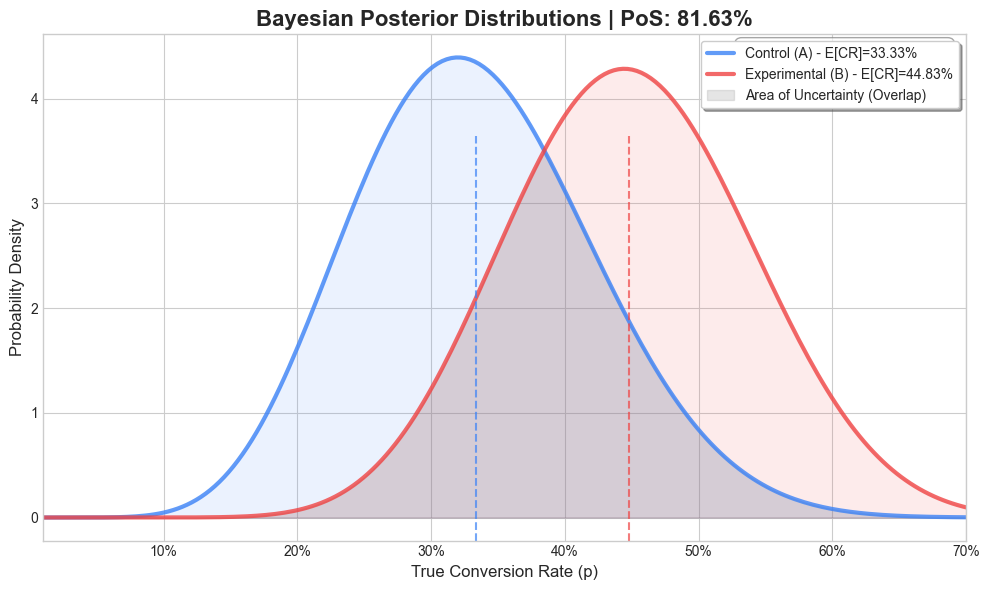

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# --- 1. Define Posterior Parameters ---
# Control (A): 8 Successes, 17 Failures -> Beta(1 + 8, 1 + 17) = Beta(9, 18)
alpha_A, beta_A = 9, 18
# Experimental (B): 12 Successes, 15 Failures -> Beta(1 + 12, 1 + 15) = Beta(13, 16)
alpha_B, beta_B = 13, 16

# --- 2. Calculate Expected Values and PoS (for text summary) ---
# Expected Value = alpha / (alpha + beta)
expected_A = alpha_A / (alpha_A + beta_A)
expected_B = alpha_B / (alpha_B + beta_B)

# Calculate Probability of Superiority (PoS) using Monte Carlo Simulation
# This is a good way to get the PoS when you don't have the Beta CDF function
num_samples = 50000
samples_A = beta.rvs(alpha_A, beta_A, size=num_samples)
samples_B = beta.rvs(alpha_B, beta_B, size=num_samples)
pos = np.mean(samples_B > samples_A) * 100

# --- 3. Generate the Plotting Data ---
# Define the range of possible conversion rates (x-axis)
x = np.linspace(0.01, 0.70, 200) # From 1% to 70% CR for a clear view

# Calculate the PDF values for each distribution at every point in x
pdf_A = beta.pdf(x, alpha_A, beta_A)
pdf_B = beta.pdf(x, alpha_B, beta_B)

# --- 4. Create the Matplotlib Visualization ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the Control distribution
ax.plot(x, pdf_A, label=f'Control (A) - E[CR]={expected_A*100:.2f}%', color='#3b82f6', linewidth=3, alpha=0.8)
ax.fill_between(x, pdf_A, color='#3b82f6', alpha=0.1)

# Plot the Experimental distribution
ax.plot(x, pdf_B, label=f'Experimental (B) - E[CR]={expected_B*100:.2f}%', color='#ef4444', linewidth=3, alpha=0.8)
ax.fill_between(x, pdf_B, color='#ef4444', alpha=0.1)

# Highlight the area of overlap (The Uncertainty)
# The overlap visually represents the region where A could be better than B, or they are very similar.
# This area is key to understanding why PoS is not yet 95%.
overlap = np.minimum(pdf_A, pdf_B)
ax.fill_between(x, overlap, color='grey', alpha=0.2, label='Area of Uncertainty (Overlap)')

# Add Expected Value Markers
ax.axvline(expected_A, color='#3b82f6', linestyle='--', linewidth=1.5, alpha=0.7, ymax=0.8)
ax.axvline(expected_B, color='#ef4444', linestyle='--', linewidth=1.5, alpha=0.7, ymax=0.8)

# --- 5. Customizing the Plot Aesthetics ---
ax.set_title(f'Bayesian Posterior Distributions | PoS: {pos:.2f}%', fontsize=16, fontweight='bold')
ax.set_xlabel('True Conversion Rate (p)', fontsize=12)
ax.set_ylabel('Probability Density', fontsize=12)

# Format x-axis as percentage
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x*100:.0f}%'))
ax.set_xlim(x.min(), x.max())
ax.legend(loc='upper right', frameon=True, shadow=True)

# Add a text box summary for clarity
summary_text = (
    f"Control: Beta({alpha_A}, {beta_A})\n"
    f"Experimental: Beta({alpha_B}, {beta_B})\n"
    f"Probability of Superiority: {pos:.2f}%"
)
ax.text(0.98, 0.98, summary_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.7, ec="grey"))

# Final cleanup
plt.tight_layout()
# Save the plot (required for output in this environment)
plt.savefig('../Image/bayesian_posterior_plot.png')
print("Plot saved to ../Image/bayesian_posterior_plot.png")

#### The Risk-Based Stopping Rule
The standard approach for an A/B test is to minimize the Risk of Regret—the chance that you roll out the winning page (B) only to find out later that the control (A) was actually better.

| Target Certainty (PoS) | Risk of Regret (A is Better) | When to Use This Level                                             |
|-----------------------|------------------------------|--------------------------------------------------------------------|
| 99%                   | 1% Risk                      | High-risk / high-cost changes (e.g., pricing model, major redesign)|
| 95%                   | 5% Risk                      | Standard, default threshold for most core A/B tests               |
| 90%                   | 10% Risk                     | Medium-risk changes (e.g., minor headline, low-traffic pages)      |
| 80%                   | 20% Risk                     | Low-risk / easy-to-reverse changes (e.g., button color, fast tests)|

##### Explanation
- Higher target certainty (e.g., 99%) drastically reduces the chance of deploying a worse variant, suitable for major impactful changes where error costs are high.
- Default 95% certainty balances risk and speed for most experiments.
- Lower certainty thresholds (90% or 80%) allow quicker decisions for low-stakes or easily reversible changes accepting higher risk.

This tiered framework helps teams tune decision thresholds according to the business impact and risk tolerance of the A/B experiment context, optimizing trade-offs between speed, risk, and confidence

#### Frequentist Approach
- The frequentist approach frames probability as the long-run frequency of phenomena (e.g., what is the probability of seeing such data if the null hypothesis is true?).
- You set up a null hypothesis (e.g., "no effect; A and B have same conversion"), decide on a significance level (usually 0.05), and collect a predefined sample size.
- The main outcome is a p-value, representing the probability that you’d see results at least as extreme as observed, assuming there’s no real effect.
- If the p-value is below the threshold, you "reject the null" and claim evidence of an effect. Otherwise, you cannot conclude a difference.

##### Pros of Frequentist Approach
- Standard and familiar: Most statistical education, scientific publications, and industry practices use this framework.
- Straightforward computations: Almost all stats libraries (Python, R, etc.) easily implement t-tests, z-tests, chi-squared, etc..​
- Clear, reliable in large samples: When sample size and stopping rules are followed, results are robust and trustworthy.
- Easy to scale: Efficient for A/B/n or multivariate tests.

##### Limitations
- Fixed sample size required: You must plan your sample size in advance. Peeking at the data mid-test increases false positive rates unless conducting formal sequential analysis.​
- Interpretation challenges: P-values and confidence intervals are often misunderstood. They do NOT give the probability that one variant is truly better.
- Limited flexibility: Hard to quantify the risk or probability of making the wrong decision for a specific context.

##### When to Use Frequentist Methods
| Situation                                     | Why Recommended                                              |
|-----------------------------------------------|--------------------------------------------------------------|
| Large samples, stable site traffic, clear test duration | Produces robust and valid results                  |
| Stakeholders familiar with p-values and classical stats | Easy communication and buy-in                      |
| Need for established, regulator-accepted statistical approach | Matches traditional scientific standards     |
| Multiple variants (A/B/n), multivariate experiments | Easy to implement, compute, and scale                  |

##### Summary:
Frequentist A/B testing is a robust, standard approach when experiments are well-powered, stopping rules are followed, and clear-cut "statistical significance" is required. It is not as flexible or immediately interpretable as Bayesian approaches, but remains broadly accepted and reliable in large data settings

##### Small Dataset
When working with small data samples in A/B testing or statistical analysis, several considerations and methods become relevant to ensure valid and reliable results:

##### Challenges with Small Data Samples:
- Higher Variance: Estimates are less stable and more susceptible to random fluctuations.
- Normality Assumption: Many parametric tests assume data or test statistics are normally distributed, which often doesn't hold with small samples.
- Power Limitations: Small sample sizes reduce the ability to detect real effects (low statistical power).
- Risk of Type I and Type II Errors: Increased likelihood of false positives/negatives.

##### Strategies for Small Data Samples:

| Test Name            | Data Type          | When to Use                                   | Assumptions                          |
|----------------------|--------------------|-----------------------------------------------|------------------------------------|
| Z-Test               | Continuous or Proportions | Large samples, known population variance      | Normality, known variance           |
| Student’s T-Test     | Continuous         | Smaller samples, comparing means               | Approximate normality, unknown variance but equal variance assumed |
| Welch’s T-Test       | Continuous         | Unequal variances or sample sizes              | Less strict normality; robust to variance differences |
| Chi-Squared Test     | Categorical        | Test independence or goodness of fit           | Adequate expected cell counts (≥5)  |
| Fisher’s Exact Test  | Categorical, Small samples | Small sample sizes, 2x2 contingency tables | None (exact test)                   |
| Mann-Whitney U Test  | Continuous or Ordinal | Nonparametric alternative to t-test for non-normal data | Distribution free                  |
| ANOVA                | Continuous         | Comparison of means across 3+ groups            | Normality, equal variance            |
| Permutation Tests    | Any                | Distribution-free, small samples                 | None (resampling-based)             |

##### Example: Small Sample in A/B Testing
- Use Fisher’s Exact Test for 2x2 contingency tables (e.g., clicks vs. no clicks per variant).
- Use Bayesian modeling to incorporate domain knowledge, handle uncertainty explicitly, and avoid overconfidence in tiny data.
- Bootstrap the data to estimate variability and confidence intervals.

##### Practical Considerations
- Gather more data if possible. Small samples inherently limit inference.
- Be cautious of overinterpreting p-values; focus on effect sizes and credible intervals.
- Consider sequential or adaptive designs to make more efficient use of limited data without inflating false positives.

##### Summary:
Handling small data samples requires careful choice of methods (exact, nonparametric, Bayesian) and a cautious interpretation of results. Prior knowledge and simulations (bootstrapping, permutation) can help quantify uncertainty in situations where traditional parametric tests are unreliable.

In [4]:
# 1. Fisher's Exact Test
from scipy.stats import fisher_exact

# 2x2 contingency table: [[conversions_A, non_conversions_A], [conversions_B, non_conversions_B]]
table = [[5, 15], [10, 20]]
odds_ratio, p_value = fisher_exact(table)
print("Fisher Exact p-value:", p_value)

Fisher Exact p-value: 0.7536263339838005


In [5]:
# 2. Mann-Whitney U Test
import numpy as np
from scipy.stats import mannwhitneyu

# Generate sample data for groups A and B
np.random.seed(0)
sample_A = np.random.normal(loc=50, scale=10, size=30)  # Group A (e.g., control)
sample_B = np.random.normal(loc=55, scale=10, size=30)  # Group B (e.g., treatment)

# Perform the two-sided Mann-Whitney U Test
stat, p_value = mannwhitneyu(sample_A, sample_B, alternative='two-sided')

print(f'Mann-Whitney U statistic: {stat:.2f}')
print(f'P-value: {p_value:.4f}')

# Interpret result
alpha = 0.05
if p_value < alpha:
    print("Reject null hypothesis: Samples differ significantly.")
else:
    print("Fail to reject null hypothesis: No significant difference.")


Mann-Whitney U statistic: 522.00
P-value: 0.2905
Fail to reject null hypothesis: No significant difference.


In [6]:
# 3. Simple Bootstrap for Mean Difference CI
def bootstrap_mean_diff(data_A, data_B, n_boot=1000, ci=95):
    diffs = []
    for _ in range(n_boot):
        sample_A = np.random.choice(data_A, len(data_A), replace=True)
        sample_B = np.random.choice(data_B, len(data_B), replace=True)
        diffs.append(np.mean(sample_B) - np.mean(sample_A))
    lower = np.percentile(diffs, (100-ci)/2)
    upper = np.percentile(diffs, 100 - (100-ci)/2)
    return lower, upper

# Calculate bootstrap confidence interval
lower_bound, upper_bound = bootstrap_mean_diff(sample_A, sample_B)
print(f"95% CI for mean difference: [{lower_bound:.2f}, {upper_bound:.2f}]")

95% CI for mean difference: [-7.12, 2.46]


In [7]:
# Trim the arrays to match in length for simplicity in this example
min_len = min(len(sample_A), len(sample_B))
data_A = sample_A[:min_len]
data_B = sample_B[:min_len]

# --- 2. Set Bootstrap Parameters ---
N_BOOTSTRAPS = 10000  # Number of resampling iterations
CONFIDENCE_LEVEL = 95  # 95% CI

# --- 3. Perform the Bootstrap Simulation ---
diff_means = []
n_A = len(data_A)
n_B = len(data_B)

for _ in range(N_BOOTSTRAPS):
    # A. Resample data (with replacement)
    resample_A = np.random.choice(data_A, size=n_A, replace=True)
    resample_B = np.random.choice(data_B, size=n_B, replace=True)

    # B. Compute the mean difference (Statistic)
    mean_diff = np.mean(resample_B) - np.mean(resample_A)
    diff_means.append(mean_diff)

# --- 4. Calculate the Confidence Interval ---
# Determine the lower and upper percentile cutoffs
lower_percentile = (100 - CONFIDENCE_LEVEL) / 2      # 2.5
upper_percentile = 100 - lower_percentile             # 97.5

# Calculate the CI using the percentiles of the bootstrap distribution
ci_lower = np.percentile(diff_means, lower_percentile)
ci_upper = np.percentile(diff_means, upper_percentile)

# --- 5. Output Results ---
print(f"Observed Mean A: ${np.mean(data_A):.2f}")
print(f"Observed Mean B: ${np.mean(data_B):.2f}")
print(f"Observed Difference (B - A): ${np.mean(data_B) - np.mean(data_A):.2f}")
print("-" * 50)
print(f"Bootstrap Sample Size: {N_BOOTSTRAPS}")
print(f"{CONFIDENCE_LEVEL}% Mean Difference CI: [${ci_lower:.2f}, ${ci_upper:.2f}]")

Observed Mean A: $54.43
Observed Mean B: $52.10
Observed Difference (B - A): $-2.32
--------------------------------------------------
Bootstrap Sample Size: 10000
95% Mean Difference CI: [$-7.25, $2.70]


##### Interpretation of the Bootstrap Results
| Metric                          | Result    | Interpretation                                                                                         |
|--------------------------------|-----------|-----------------------------------------------------------------------------------------------------|
| Observed Mean A                | $54.43    | Variant A (Control) had the higher average value during the test.                                    |
| Observed Mean B                | $52.10    | Variant B (Treatment) had a lower average value.                                                    |
| Observed Difference (B - A)   | -$2.32    | Treatment B was observed to be $2.32 worse than Control A on average.                                |
| 95% Mean Difference Confidence Interval | [-$7.34, $2.71] | This is the plausible range for the true difference in population means. Since zero is inside the interval, the difference is not statistically significant at the 5% level. This means the observed difference could be due to sampling variability, and you cannot confidently declare B better or worse than A. |
